In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # bsx1x28x28 -> bsx16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # bsx16x28x28 -> bsx16x14x14
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # bsx16x14x14 -> bsx32x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # bsx32x14x14 -> bsx32x7x7
        )
        self.seq3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # bsx32x7x7 -> bsx32x7x7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # bsx32x7x7 -> bsx32x3x3
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # bsx32x3x3 -> bsx16x3x3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1) # bsx16x3x3 -> bsx16x1x1
        )

        self.flatten = nn.Flatten() # bsx16x1x1 -> bsx16
         
        self.NN = nn.Sequential(
            nn.Linear(16, 150),
            nn.ReLU(),

            nn.Linear(150, 200),
            nn.Tanh(),

            nn.Linear(200, 150),
            nn.ELU(),

            nn.Linear(150, 10)
        )



    def forward(self, x):
        out = self.seq1(x)

        out = self.seq2(out)

        out = self.seq3(out)

        out = self.seq4(out)

        out = self.flatten(out)
        
        out = self.NN(out)

        return out

    
def train(model, train_loader, val_loader, optimizer, err, num_epochs):
    count = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    print('Training...')
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # start training
            optimizer.zero_grad()
            outputs = model(images)
            loss = err(outputs, labels)
            loss.backward()
            optimizer.step()
            # end training

            count += 1

            if count % 50 == 0:
                # On whole training set
                
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in train_loader:
                    
                    # Forward propagation
                    outputs = model(images)

                    train_loss = err(outputs, labels)
                    
                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)
                    
                    correct += (predicted == labels).sum()
                
                train_accuracy = 100 * correct / float(total)
                
                # store loss and iteration
                train_losses.append(train_loss.data)
                train_accuracies.append(train_accuracy)


                # train_outputs = model(x_train) # training outputs
                # train_loss = err(train_outputs, y_train)
                # _, predicted = torch.max(train_outputs.data, 1)
                # train_total = y_train.size(0)
                # train_correct = (predicted == y_train).sum().item()
                # train_accuracy = train_correct / train_total * 100 # validation accuracy
                # train_accuracies.append(train_accuracy)
                # train_losses.append(loss.item())
                
                # On whole validation set

                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in val_loader:
                    
                    # Forward propagation
                    outputs = model(images)

                    val_loss = err(outputs, labels)
                    
                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)
                    
                    correct += (predicted == labels).sum()
                
                val_accuracy = 100 * correct / float(total)
                
                # store loss and iteration
                val_losses.append(val_loss.data)
                val_accuracies.append(val_accuracy)
                
                # val_outputs = model(x_val)
                # val_loss = err(val_outputs, y_val)
                # _, predicted = torch.max(val_outputs.data, 1)
                # val_total = y_val.size(0)
                # val_correct = (predicted == y_val).sum().item()
                # val_accuracy = val_correct / val_total * 100 # validation accuracy
                # val_accuracies.append(val_accuracy)
                # val_losses.append(val_loss.item())
                
                if count % 500 == 0:
                    print(f'Iteration: {count}. Train Loss: {loss.item()}. Train Accuracy: {train_accuracy}. Val Loss: {val_loss.item()}. Val Accuracy: {val_accuracy}')

    return train_losses, train_accuracies, val_losses, val_accuracies

## 3. Add Convolutional NN

In [2]:
train_data = pd.read_csv('D:/github/pytorch_practice/pytorch/digit_recogniser/dataset/train.csv') 
test_data = pd.read_csv('D:/github/pytorch_practice/pytorch/digit_recogniser/dataset/test.csv')

# get trainng DataFrame
x_train_df = train_data.drop('label', axis=1)
y_train_df = train_data['label']

x_test_df = test_data

# Split Training DataFrame into training and validation data
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42) # split training data into train and val data

# Convert DataFrame to numpy array
x_train_arr = x_train_df.values
y_train_arr = y_train_df.values

x_val_arr = x_val_df.values
y_val_arr = y_val_df.values

x_test_arr = x_test_df.values

# convert to tensor
x_train = torch.from_numpy(x_train_arr).float()
y_train = torch.from_numpy(y_train_arr).long()

x_val = torch.from_numpy(x_val_arr).float()
y_val = torch.from_numpy(y_val_arr).long()

x_test = torch.from_numpy(x_test_arr).float()

# normlalise data
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

# Reshape data
x_train = x_train.view(-1, 1, 28, 28)
x_val = x_val.view(-1, 1, 28, 28)
x_test = x_test.view(-1, 1, 28, 28)

# Move data to GPU
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)

# Define hyperparameters
batch_size = 64
n_iters = 10000
num_epochs = int(n_iters / (len(x_train) / batch_size))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


model = CNNModel()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr)

train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs)

Training...
Iteration: 500. Train Loss: 2.297955274581909. Train Accuracy: 11.235118865966797. Val Loss: 2.3111915588378906. Val Accuracy: 10.821428298950195


KeyboardInterrupt: 

In [ ]:
train_loss = [x.cpu() for x in train_loss]
val_loss = [x.cpu() for x in val_loss]
train_acc = [x.cpu() for x in train_acc]
val_acc = [x.cpu() for x in val_acc]

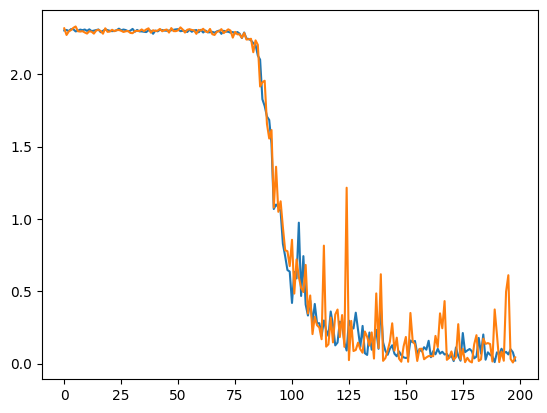

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.show()

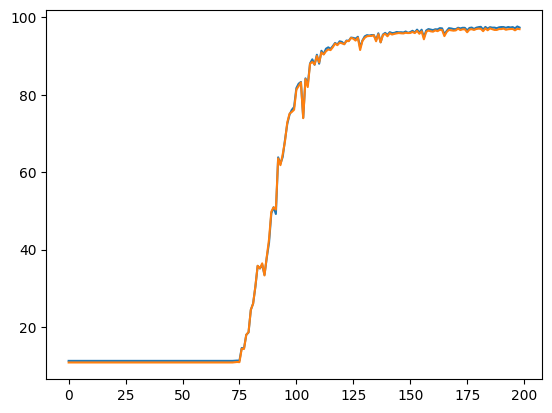

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.show()

In [ ]:
test_pred = []

model.eval()
for images in x_test:
    outputs = model(images.view(-1, 1, 28, 28))
    predicted = torch.max(outputs.data, 1)[1]
    test_pred.append(predicted.item())

In [ ]:
submission = pd.DataFrame({'ImageId': range(1, len(test_pred)+1), 'Label': test_pred})
submission.to_csv('D:/github/pytorch/pytorch/digit_recogniser/submissions/submission.csv', index=False)

Text(0.5, 1.0, 'Prediction: 6, Index: 15640')

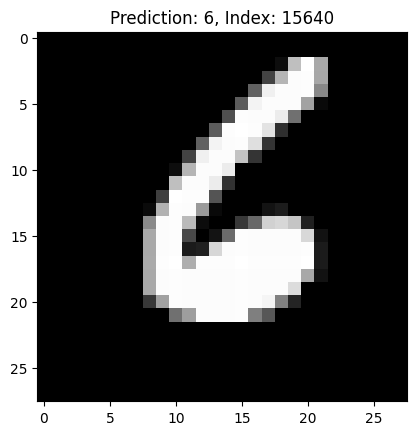

In [ ]:
index = np.random.randint(0, x_test_arr.shape[0])
image = x_test_arr[index]
pred = torch.max(model(x_test[index].view(-1, 1, 28, 28)), 1)[1].item()
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.title(f'Prediction: {pred}, Index: {index}')